# Import Modules

In [1]:
import os, sys, errno
import numpy as np
import cv2
from xml.dom import minidom
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from tqdm import tqdm
from glob import glob
import argparse

import json

# Params

In [2]:
ZONE_XML_PATH = '../example/zone_xmls'
OCR_XML_PATH  = '../example/ocr_xmls'
SAVE_PATH     = '../output'
IOU_THRESHOLD = 0.1
DEBUG = True

In [3]:

zone_xml_file_paths = glob(os.path.join(ZONE_XML_PATH,'**/*.xml'),recursive=True)
ocr_xml_file_paths  = glob(os.path.join(OCR_XML_PATH,'**/*.xml'),recursive=True)

idx = 1

zone_xml_file_path = zone_xml_file_paths[idx]
ocr_xml_file_path  = ocr_xml_file_paths[idx]


print("[{}/{}] Processing \nzone xml: {}\nOCR xml: {}".format(idx+1,len(zone_xml_file_paths),zone_xml_file_path,ocr_xml_file_path))


#img    = cv2.imread(img_path)

[2/2] Processing 
zone xml: ../example/zone_xmls/sn86058242-19200121_dhSegment.xml
OCR xml: ../example/ocr_xmls/sn86058242-19200121.xml


# Zone Processing

In [4]:
# Read Zone xml
xmldoc = minidom.parse(zone_xml_file_path)

# Get image dimension and resize factor
#img_w  = int(xmldoc.getElementsByTagName('Page')[0].attributes['WIDTH'].value)
#img_h  = int(xmldoc.getElementsByTagName('Page')[0].attributes['HEIGHT'].value)

img_w  = int(xmldoc.getElementsByTagName('Page')[0].attributes['WIDTH'].value)
img_h  = int(xmldoc.getElementsByTagName('Page')[0].attributes['HEIGHT'].value)

# Count number of text-blocks
zone_textBlocks = xmldoc.getElementsByTagName('TextBlock')

if DEBUG:
    print("Zone XML:")
    print("{} \tWidth (factored)".format(img_w)) 
    print("{} \tHeight (factored)".format(img_h))
    print("{} \tTextBlock(s)".format(len(zone_textBlocks)))


Zone XML:
5888 	Width (factored)
7922 	Height (factored)
20 	TextBlock(s)


# OCR Processing

In [5]:

# Read OCR xml
xmldoc = minidom.parse(ocr_xml_file_path)

# Get image dimension and resize factor
image_width  = int(xmldoc.getElementsByTagName('Page')[0].attributes['WIDTH'].value)
image_height = int(xmldoc.getElementsByTagName('Page')[0].attributes['HEIGHT'].value)

_processingStepSettings = str(xmldoc.getElementsByTagName('processingStepSettings')[0].childNodes[0].nodeValue)
_attributes = _processingStepSettings.split('\n')
        
factor = img_w/image_width

# Count number of text-blocks
ocr_textBlocks = xmldoc.getElementsByTagName('TextBlock')

if DEBUG:
    print("OCR XML:")
    print("{} \tWidth (original)".format(image_width)) 
    print("{} \tHeight (original)".format(image_height))
    print("{} \tWidth (factored)".format(img_w)) 
    print("{} \tHeight (factored)".format(img_h))
    print("{} \tTextBlock(s)".format(len(ocr_textBlocks)))


OCR XML:
23548 	Width (original)
31688 	Height (original)
5888 	Width (factored)
7922 	Height (factored)
87 	TextBlock(s)


# Mapping

In [6]:
"""
MAPPING
"""
# output json
map_json = []

for zone_idx,zone_textBlock in enumerate(tqdm(zone_textBlocks)):
    # zone coordinates
    zone_width  = int(zone_textBlock.attributes["WIDTH"].value)
    zone_height = int(zone_textBlock.attributes["HEIGHT"].value)
    zone_vpos   = int(zone_textBlock.attributes["VPOS"].value)
    zone_hpos   = int(zone_textBlock.attributes["HPOS"].value)
    
    zone_p1 = (zone_hpos,zone_vpos)
    zone_p2 = ((zone_hpos+zone_width),zone_vpos)
    zone_p3 = (zone_hpos,(zone_vpos+zone_height))
    zone_p4 = ((zone_hpos+zone_width),(zone_vpos+zone_height))
    
    zone_coord = [zone_p3, zone_p4, zone_p2, zone_p1]
    
    # Build json
    _textBlock_xml = {}
    _textBlock_xml["zone_coord"] = [list(zone_p3), list(zone_p4), list(zone_p2), list(zone_p1)]
    _matching_ocr_textBlocks = []
    _matching_ocr_contents   = []
    
    for ocr_idx,ocr_textBlock in enumerate(ocr_textBlocks):
        # OCR coordinates
        ocr_width  = int(ocr_textBlock.attributes["WIDTH"].value)
        ocr_height = int(ocr_textBlock.attributes["HEIGHT"].value)
        ocr_vpos   = int(ocr_textBlock.attributes["VPOS"].value)
        ocr_hpos   = int(ocr_textBlock.attributes["HPOS"].value)
    
        width  = int(ocr_width*factor)
        height = int(ocr_height*factor)
        vpos   = int(ocr_vpos*factor)
        hpos   = int(ocr_hpos*factor)
        
        ocr_p1 = (hpos,vpos)
        ocr_p2 = ((hpos+width),vpos)
        ocr_p3 = (hpos,(vpos+height))
        ocr_p4 = ((hpos+width),(vpos+height))
        
        ocr_coord = [ocr_p3, ocr_p4, ocr_p2, ocr_p1]
        
        # Find matching regions
        zone_polygon = Polygon(zone_coord)
        ocr_polygon  = Polygon(ocr_coord)
        
        iou = zone_polygon.intersection(ocr_polygon).area / zone_polygon.union(ocr_polygon).area
        
        if(iou >= IOU_THRESHOLD):
            # OCR Contents
            contents = ''
            ocr_textLines = ocr_textBlock.getElementsByTagName('TextLine')
            for ocr_textline in ocr_textLines:
                strings = ocr_textline.getElementsByTagName('String')
                for string in strings:
                    contents += (str(string.attributes["CONTENT"].value) + ' ')

            # Build json
            _matching_ocr_textBlocks.append([list(ocr_p3), list(ocr_p4), list(ocr_p2), list(ocr_p1)])
            _matching_ocr_contents.append(contents)

    # Build json
    _textBlock_xml["ocr_coords"] = _matching_ocr_textBlocks
    _textBlock_xml["ocr_texts"] =_matching_ocr_contents
    map_json.append(_textBlock_xml)

# Save json
data = json.dumps(map_json)
out_json_filename = os.path.basename(ocr_xml_file_path).split('.')[0] + '.json'
with open(os.path.join(SAVE_PATH,out_json_filename),'w') as out_json_fp:
    json.dump(map_json, out_json_fp) 


100%|██████████| 20/20 [00:00<00:00, 89.98it/s]


# Visualization

Load ../output/sn86058242-19200121.json
Total 20 zones are found by dhSegment.

Inspect zone 3 out of 20:
OCR text of region 1:
Revolt in Favor of General Obregon Stirs President to Action. 'INTERNATIONAL NEWS SERVICE1 SAX ANTONIO. Tex.. Jan. CI. Fol 'wing unconfirmed reports that Hen. nhrgon 15 in rpn revolt again?: ar-t--nza adx-ices reachci here today sta-t- K that Carranza has ordered conecii : . .ted in Mexico'ity ail the raiiroj.il : ..terial and rolling stock iti the neigh- l "-ning state of Michcacan. i The dispatches relating to tn revolt. j t? received with credem by the Mex . sr? hire. A pariilel is drawn bftwi .1' jnvernmnt's present concentration: id'r and similar step? taken by Cat - j tsza in 1316 when Villa was preparing: i launch a rebellion in Asms Calient?.) The rumors regarding the revolt.! r,n( from several sources in private i 'spatche to Mexicans in San Antonio : nd f:om travelers returning tcom j tfxico. These report a revolution! fifvin; in Sonora in favor of O

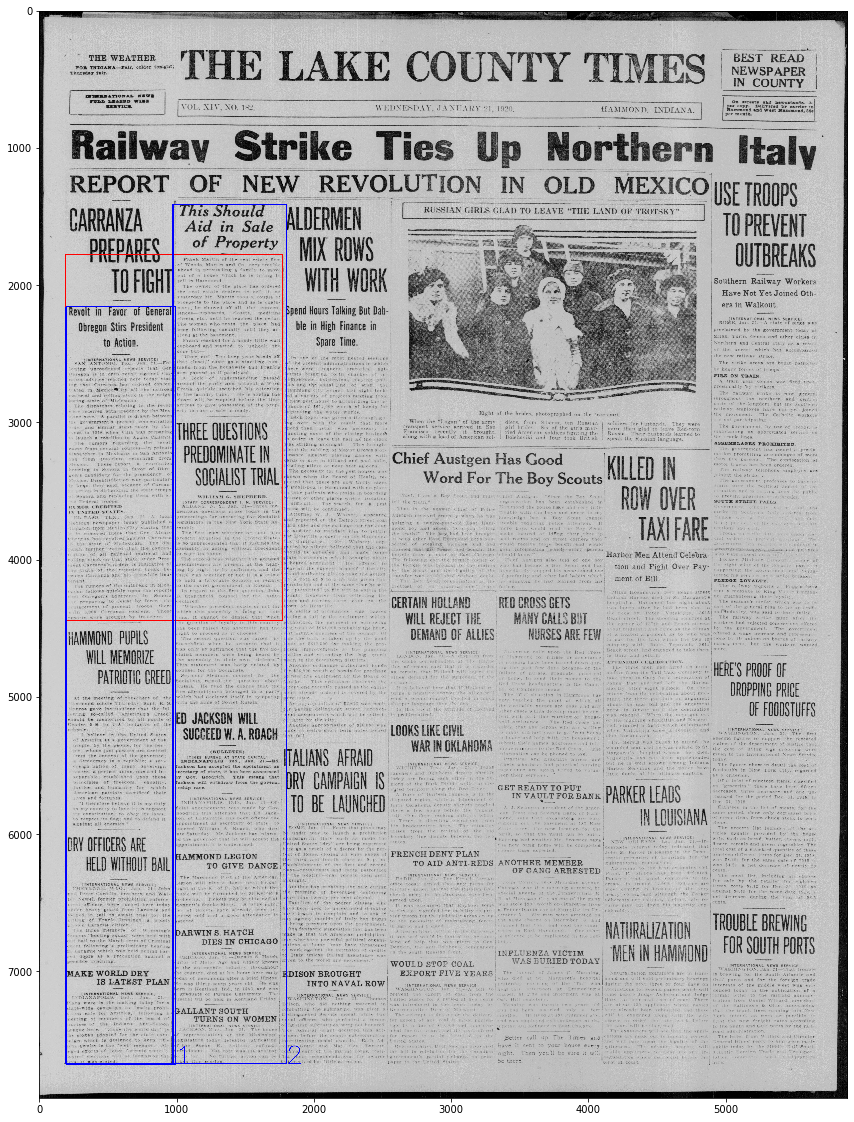

In [7]:
json_files = glob(os.path.join(SAVE_PATH,'**/*.json'),recursive=True)
json_file = json_files[0]

print("Load {}".format(json_file))

data = None
with open(json_file) as in_json_fp:
    data = json.load(in_json_fp)
print("Total {} zones are found by dhSegment.\n".format(len(data)))

# Change index number for further inspection
zone_idx = 2

print("Inspect zone {} out of {}:".format(zone_idx+1,len(data)))
zone_textBox = data[zone_idx]

img = cv2.imread(os.path.join("../example/images",os.path.basename(json_file).split('.')[0] + '.jpg'))
canvas = np.copy(img)

# Draw zone region (red color)
cv2.drawContours(canvas,np.int32([np.array(zone_textBox['zone_coord'])]),0,(255,0,0),10)

for ocr_idx in range(len(zone_textBox['ocr_coords'])):
    # Draw zone region (blue color)
    cv2.drawContours(canvas,np.int32([np.array(zone_textBox['ocr_coords'][ocr_idx])]),0,(0,0,255),10)
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    topLeftCornerOfText    = tuple(zone_textBox['ocr_coords'][ocr_idx][1])
    fontScale              = 6
    fontColor              = (0,0,255)
    lineType               = 6
    cv2.putText(canvas, str(ocr_idx+1), topLeftCornerOfText, font, fontScale, fontColor,lineType, cv2.LINE_AA)

    print("OCR text of region {}:\n{}\n".format(ocr_idx+1,zone_textBox['ocr_texts'][ocr_idx]))
    
plt.figure(figsize=(20,20))
plt.imshow(canvas)
plt.show()